In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import mannwhitneyu

/Users/anushavan/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
plt.style.use('ggplot')

In [4]:
%matplotlib inline

In [5]:
data = pd.read_csv('data/cleaned_data.csv', 
                   parse_dates=['Fully Paid','Approved']).drop(['Unnamed: 0'],axis=1)

In [6]:
data.columns

Index(['Borough', 'Building Type', 'Efiling Filed',
       'Applicant Professional Title', 'Professional Cert', 'Fully Paid',
       'Approved', 'Total Est. Fee', 'Proposed Zoning Sqft',
       'Proposed No. Of Stories', 'Proposed Height', 'Proposed Dwelling Units',
       'Proposed Occupancy', 'Zoning Dist1', 'Zoning Dist2', 'Zoning Dist3',
       'Special District 1', 'Special District 2', 'Non-Profit',
       'Total_Construction_Floor_Area', 'Signoff_Date', 'Duration', 'Z_score'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59076 entries, 0 to 59075
Data columns (total 23 columns):
Borough                          59076 non-null object
Building Type                    59076 non-null object
Efiling Filed                    59076 non-null object
Applicant Professional Title     59076 non-null object
Professional Cert                59076 non-null object
Fully Paid                       59076 non-null datetime64[ns]
Approved                         59076 non-null datetime64[ns]
Total Est. Fee                   59076 non-null float64
Proposed Zoning Sqft             59076 non-null int64
Proposed No. Of Stories          59076 non-null int64
Proposed Height                  59076 non-null int64
Proposed Dwelling Units          50387 non-null float64
Proposed Occupancy               58902 non-null object
Zoning Dist1                     58903 non-null object
Zoning Dist2                     4720 non-null object
Zoning Dist3                     202 non-null object

In [8]:
sorted_data = data.sort_values(by='Fully Paid')

In [9]:
approved_annual = data.groupby(data['Fully Paid'].dt.year).count()

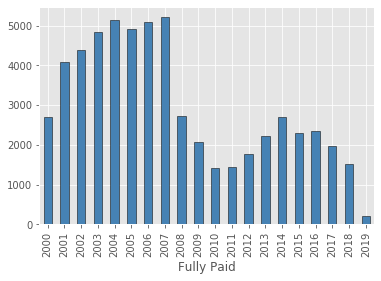

In [10]:
approved_annual.Approved.plot(kind='bar', color='steelblue', edgecolor='k');


##### Past vs present data

* We need to find out if the past data is still relevant for today to make the predictions. 
* create a subset of the first five years and the last five years and conduct a statistical analysis to check if these data is similar. 
    * H0: the first five year's of data has the same mean as the last five years
    * H1: the first five year's of data has a different mean form the last five years.
* Test the null hypothesis by conducting a t-test:
    * We need to check if the data is normally distributed before we can run the t-test. 
    * if the data is not normal, then we can run a Mann Whitney U test to check if the distributions are similar. 

In [11]:
first_five = sorted_data[sorted_data['Fully Paid'] < '2006-01-01']

In [12]:
last_five = sorted_data[sorted_data['Fully Paid'] >= '2015-05-15']

In [13]:
first_last = [first_five['Duration'],last_five['Duration']]

,First_five,Last_five
count,26090.0,7573.0
mean,138.0,198.0
std,263.0,184.0
50%,48.0,147.0
max,4959.0,1392.0


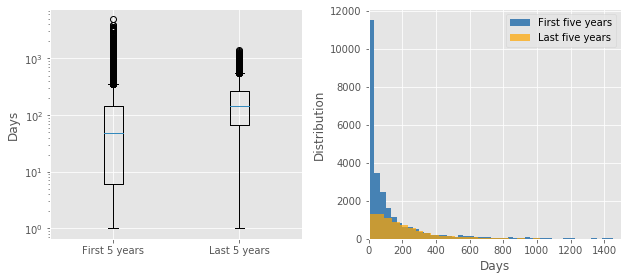

In [14]:
# Check if the first_five and last_five distributions are normal
fig,[ax1,ax2] = plt.subplots(1,2, figsize=(9,4))
ax1.boxplot(first_last);
ax1.set_ylabel('Days')
ax1.set_yscale('log')
ax1.set_xticklabels(['First 5 years','Last 5 years']);

# histogram of the 2 distributions
plt.hist(first_five['Duration'],bins=150, label='First five years',color='steelblue');
plt.hist(last_five['Duration'],bins=30, label='Last five years',color='orange', alpha=0.7);
plt.ylabel('Distribution')
plt.xlabel('Days')
plt.xlim(0,1500)
plt.legend();
plt.tight_layout()
pd.concat([first_five.Duration.describe(),last_five.Duration.describe()],
          axis=1, keys=['First_five','Last_five']).loc[['count',
                                                        'mean','std','50%','max']].round()

# fig.savefig('first_last_five.png')

#### Discussion
* The above histogram shows that the first five year and the last five year have distinctly different distributions. The mean, std, median and extreme values are all different. 
* From the boxplot distributions and the histograms we can conclude that the data is NOT normally distributed. Therefore, we will try Mann–Whitney U test to check if the distributions are comparable (equal). 

In [15]:
# conduct the Mann-Whitney U test
x = first_five['Duration']
y = last_five['Duration'] 

mannwhitneyu(x, y, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=57250003.0, pvalue=0.0)

#### Discussion
* The p-value is 0, meaning that we can reject the null hypothesis that the 2 groups are similarly distributed. In other words, with very high level of confidence we can state that the 2 groups are NOT similarly distributed. 
* This implies that we might need to use only the last 5 years of data for the predictive analysis. 

#### Examine correlations between the dependend variable (duration) and independent variables
* Since the target variable is continuous (duration), we will use regression analysis.
* For some of the independent variables that are categorical, we can create dummy variables. 

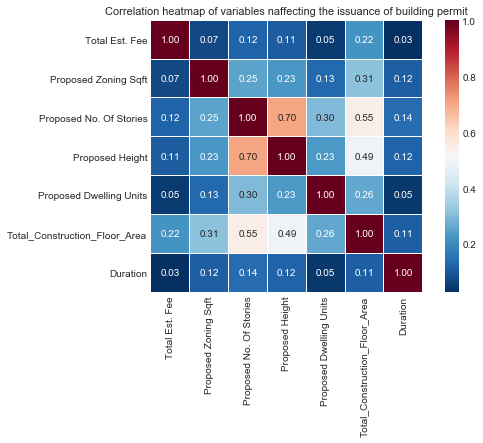

In [55]:
corr = data.drop(columns=['Z_score']).corr()
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corr, cmap="RdBu_r", annot=True, fmt='.2f', 
            linewidths=.05, square=True, ax=ax)
ax.set_title('Correlation heatmap of variables n\
affecting the issuance of building permit', fontsize=11);

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values

In [25]:
recent_df = data[data['Fully Paid'] > '2014-05-15']

In [18]:
# OLS regression of duration vs proposed zoning sqft
# X is the independent/explanatory variable. Selecting 3 ind. variables from the data. 
X = recent_df[['Proposed Zoning Sqft','Proposed No. Of Stories']]
X.columns=['Zoning Sqft','No. Of Stories']
Y = recent_df['Duration'] # Y is the dependent variable
 
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X, missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     262.0
Date:                Fri, 25 Oct 2019   Prob (F-statistic):          1.04e-111
Time:                        15:36:31   Log-Likelihood:                -68663.
No. Observations:               10248   AIC:                         1.373e+05
Df Residuals:                   10245   BIC:                         1.374e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            175.5010      2.478     70.

/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Discussion

* Out of all continuous independent variables, only the Proposed Zoning Sqft and No. Of Stories have statistically significant explanatory value. 
* However, the zoning square feet effect is very small, almost negligable. 
* The number of stories however has a significant impact on the duration. The duration will increase on average by 9 days for every additional floor added to the project. 

* **Intercept**: If the proposed zoning feet, number or stories and the total construction floor * area are 0, the duration will be 175.7 days. 

In [19]:
df_cat = pd.get_dummies(recent_df[['Borough', 'Building Type', 'Efiling Filed',
        'Applicant Professional Title', 'Professional Cert']], drop_first = True)
df_cat['intercept'] = 1
df_cat['Duration'] = recent_df['Duration']
df_cat = df_cat.rename(columns={'Building Type_OTHERS':'Building Type',
                                'Efiling Filed_Y':'Efiled',
                               'Applicant Professional Title_RA':'Pro Title',
                               'Professional Cert_Y':'Pro Certified'})
df_cat.head()

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,intercept,Duration
0,0,0,1,0,0,1,1,0,1,158.0
3,0,0,1,0,0,1,1,1,1,87.0
4,1,0,0,0,1,1,1,0,1,193.0
5,0,0,0,1,0,1,1,0,1,234.0
6,1,0,0,0,1,1,1,0,1,89.0


In [20]:
mod = sm.OLS(df_cat['Duration'],df_cat[['intercept','Building Type',
                                'Efiled','Pro Title','Pro Certified',
                                'Borough_BROOKLYN','Borough_MANHATTAN',
                                'Borough_QUEENS','Borough_STATEN ISLAND']])
results = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     248.3
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:36:31   Log-Likelihood:                -68010.
No. Observations:               10248   AIC:                         1.360e+05
Df Residuals:                   10239   BIC:                         1.361e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept               275.55

#### Discussion
* All categorical variables in the model are statistically significnt (p < 0.05) except for the E-filing category. 
* Dummies
    * 'Professional Cert’: No - 0, Yes - 1
    * 'Building Type’: 1-2-3 Family - 0, Other - 1
    * 'Efiling Filed’: No - 0, Yes - 1
    * 'Applicant Professional Title’: RE - 0, RA - 1
* Base case (Intercept): 
    * if the ebuilding:
        * is in the Bronx, 
        * doesn't have professional certification, 
        * building type is "Other", 
        * application wasn't filed electronically,
        * application was submitted by a register engineer
    * then the average duration is around 275 days.
* If the application is professionally certified, the duration will be on average 91 days shorter
* If the building is a "Other" category building, the duration will be 67 days longer,
* If the application was submitted by a registered architect, the duration will be 16.5 days longer. 
* If the building is in Brooklyn, the duration will be 28.5 days shorter
* If the building is in Queens, the duration will be 49 days shorter
* If the building is in Manhattan, the duration will be 68.5 days longer
* If the building is in Staten Island, the duration will be 75.4 days shorter. 